* 请在环境变量中设置`DB_URI`指向数据库
* 请在环境变量中设置`DATAYES_TOKEN`作为通联数据登陆凭证

In [1]:
%matplotlib inline
import os
from matplotlib import pyplot as plt
import uqer
import numpy as np
import pandas as pd
from uqer import DataAPI as api
from alphamind.api import *
from alphamind.data.neutralize import neutralize

plt.style.use('ggplot')

In [2]:
_ = uqer.Client(token=os.environ['DATAYES_TOKEN'])

512647@wmcloud.com 账号登录成功


In [3]:
ref_date = '2017-06-23'
factor = 'EPS'

engine = SqlEngine(os.environ['DB_URI'])
universe = Universe('zz800')

# Algorithm Description
--------------------------

猜测的 ``neutralize`` 残差$\bar Res$计算公式：

$$\bar Res_{i,k} = \bar f_{i,k} - \sum_j \beta_{j,k} \times \bar Ex_{i, j, k}$$

其中：$k$为行业分类，$i$为该行业中第$i$只股票，$j$为第$j$个风险因子。$\bar f$为因子序列，$\bar Ex$为风险暴露矩阵。系数$\beta_{j,k}$由OLS确定。

下面的章节，我们分别比较三种``neutralize``的方法差别：

* **UQER Neutralize**

    使用优矿的SDK计算因子残差。


* **Alpha-Mind Neutralize**

    使用alpha-mind计算因子残差，alpha-mind可以由以下地址安装：
    
    ```
    https://github.com/wegamekinglc/alpha-mind
    ```

* **Direct Weighted Least Square Fit Implementation**

    直接使用scikit-learn的线性回归功能来计算因子残差。


# Raw Data
---------------------------

In [4]:
codes = engine.fetch_codes(ref_date, universe)
factor_data = engine.fetch_factor(ref_date, factor, codes)
risk_cov, risk_expousre = engine.fetch_risk_model(ref_date, codes)
total_data = pd.merge(factor_data, risk_expousre, on=['code']).dropna()

In [5]:
total_data['ticker'] = total_data.code.apply(lambda x: '{0:06}'.format(x))
total_data.set_index('ticker', inplace=True)

In [6]:
len(total_data)

800

# UQER Neutralize
-----------------------

In [7]:
%%timeit
neutralized_factor_uqer = uqer.neutralize(total_data[factor],
                                          target_date=ref_date.replace('-', ''),
                                          industry_type='short')

241 ms ± 67.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [68]:
neutralized_factor_uqer = uqer.neutralize(total_data[factor],
                                          target_date=ref_date.replace('-', ''),
                                          industry_type='short').sort_index()
df = pd.DataFrame(neutralized_factor_uqer, columns=['uqer'])
df.head(10)

,uqer
000001,0.103040
000002,-0.314564
000006,-0.069171
000008,-0.042660
000009,-0.018216
000012,0.052925
000021,0.073551
000025,-0.108673
000027,-0.029886
000028,0.367258


In [69]:
len(neutralized_factor_uqer)

800

In [70]:
risk_exposure_uqer = uqer.DataAPI.RMExposureDayGet(tradeDate=ref_date.replace('-', '')).set_index('ticker')
targeted_secs = risk_exposure_uqer.loc[neutralized_factor_uqer.index]

style_exposure = neutralized_factor_uqer.values @ targeted_secs[risk_styles].values
industry_exposure = neutralized_factor_uqer.values @ targeted_secs[industry_styles].values

exposure = pd.Series(np.concatenate([style_exposure, industry_exposure]), index=risk_styles+industry_styles)
exposure

BETA             -7.105427e-14
MOMENTUM          1.025846e-13
SIZE              2.664535e-15
EARNYILD         -4.263256e-14
RESVOL            2.375877e-14
GROWTH            8.881784e-14
BTOP             -5.817569e-14
LEVERAGE         -1.318945e-13
LIQUIDTY         -4.685141e-14
SIZENL           -3.108624e-15
Bank              8.881784e-16
RealEstate       -1.443290e-14
Health            4.218847e-14
Transportation    4.690692e-15
Mining           -4.996004e-16
NonFerMetal      -1.151856e-15
HouseApp          4.996004e-16
LeiService        9.436896e-16
MachiEquip        9.436896e-16
BuildDeco        -1.731948e-14
CommeTrade        2.975398e-14
CONMAT            3.108624e-15
Auto              1.154632e-14
Textile           4.773959e-15
FoodBever        -3.108624e-15
Electronics       3.663736e-15
Computer          3.663736e-15
LightIndus       -1.038059e-14
Utilities         2.074729e-14
Telecom          -1.165734e-15
AgriForest       -9.159340e-15
CHEM              1.409983e-14
Media   

# Alpha-Mind Neutralize
--------------------------

In [71]:
x = targeted_secs[risk_styles + industry_styles].values
y = total_data[factor].values

In [72]:
%%timeit
neutralized_factor_alphamind = neutralize(x, y, weights=np.ones(len(y)))

119 µs ± 3.1 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [73]:
neutralized_factor_alphamind = neutralize(x, y, weights=np.ones(len(y)))
alphamind_series = pd.Series(neutralized_factor_alphamind.flatten(), index=total_data.index)
df['alpha-mind'] = alphamind_series
df.head()

,uqer,alpha-mind
000001,0.103040,0.103040
000002,-0.314564,-0.314564
000006,-0.069171,-0.069171
000008,-0.042660,-0.042660
000009,-0.018216,-0.018216


In [74]:
len(alphamind_series)

800

In [77]:
style_exposure = targeted_secs[risk_styles].values.T @ neutralized_factor_alphamind
industry_exposure = targeted_secs[industry_styles].values.T @ neutralized_factor_alphamind
exposure = pd.Series(np.concatenate([style_exposure[:, 0], industry_exposure[:, 0]]), index=risk_styles+industry_styles)
exposure

BETA             -5.773160e-15
MOMENTUM         -1.065814e-14
SIZE             -5.329071e-15
EARNYILD         -2.309264e-14
RESVOL           -6.328271e-15
GROWTH            5.329071e-15
BTOP              0.000000e+00
LEVERAGE          1.398881e-14
LIQUIDTY         -1.376677e-14
SIZENL           -5.551115e-15
Bank             -1.776357e-15
RealEstate       -2.220446e-15
Health            1.332268e-15
Transportation    1.887379e-15
Mining           -1.526557e-15
NonFerMetal      -1.221245e-15
HouseApp         -9.992007e-16
LeiService       -2.775558e-17
MachiEquip       -8.604228e-16
BuildDeco         1.193490e-15
CommeTrade       -2.220446e-15
CONMAT           -2.220446e-16
Auto              1.332268e-15
Textile           3.330669e-16
FoodBever         1.776357e-15
Electronics      -3.053113e-15
Computer         -6.106227e-16
LightIndus       -2.775558e-17
Utilities        -9.436896e-16
Telecom          -4.718448e-16
AgriForest       -2.775558e-17
CHEM              6.661338e-16
Media   

# The Ticker Missing in UQER but Still in Alpha-Mind
-----------------------------------

In [78]:
missed_codes = [c for c in alphamind_series.index if c not in neutralized_factor_uqer.index]

In [79]:
total_data.loc[missed_codes]

,EPS,code,chgPct,secShortName,srisk,BETA,MOMENTUM,SIZE,EARNYILD,RESVOL,...,Telecom,AgriForest,CHEM,Media,IronSteel,NonBankFinan,ELECEQP,AERODEF,Conglomerates,COUNTRY
ticker,,,,,,,,,,,,,,,,,,,,,


# Direct Weighted Least Square Fit Implementation
------------------------

In [80]:
import statsmodels.api as sm

In [81]:
mod = sm.WLS(y, x, weights=np.ones(len(y))).fit()
lg_series = pd.Series(mod.resid, index=total_data.index)

In [82]:
df['ols'] = lg_series

# Comparison
------------------

In [83]:
df['uqer - ols'] = df['uqer'] - df['ols']
df['alphamind - ols'] = df['alpha-mind'] - df['ols']

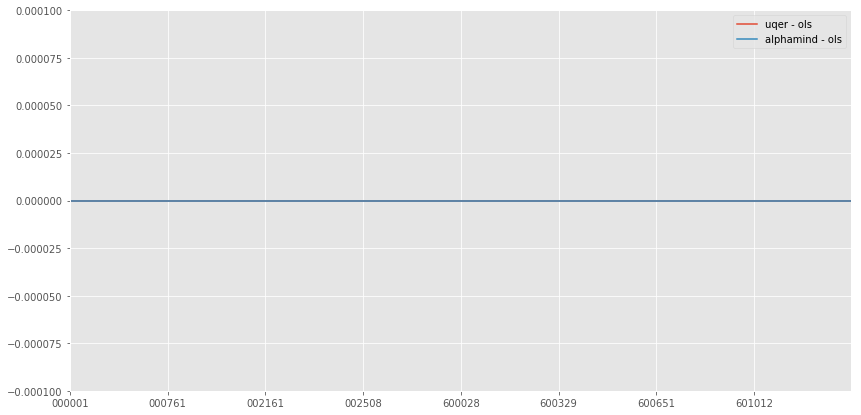

In [84]:
df[['uqer - ols', 'alphamind - ols']].plot(figsize=(14, 7), ylim=(-1e-4, 1e-4))

In [85]:
df.head()

,uqer,alpha-mind,ols,uqer - ols,alphamind - ols
000001,0.103040,0.103040,0.103040,5.551115e-16,3.053113e-16
000002,-0.314564,-0.314564,-0.314564,-5.551115e-17,1.110223e-16
000006,-0.069171,-0.069171,-0.069171,-3.885781e-16,-8.326673e-17
000008,-0.042660,-0.042660,-0.042660,2.914335e-16,0.000000e+00
000009,-0.018216,-0.018216,-0.018216,-4.579670e-16,1.665335e-16
